In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
pd.set_option('max_colwidth', 800)

TWEETS_PATH = "/content/drive/MyDrive/4412P/raw_tweets_text.csv"
SENTIMENT_PATH = "/content/drive/MyDrive/4412P/t4sa_text_sentiment.tsv"


#load data
tweets_df = pd.read_csv(TWEETS_PATH, encoding='latin-1', header=0)
sentiment_df= pd.read_csv(SENTIMENT_PATH, sep='\t', header=0)

# Basic Information

In [21]:
print(tweets_df.shape)
print(sentiment_df.shape)

(3452663, 2)
(1179957, 4)


In [22]:
print(tweets_df.head())
print(sentiment_df.head())

                   id  \
0  758014713804587008   
1  758014717990428672   
2  758014646716665857   
3  758014655071526912   
4  758014642526429184   

                                                                                                                                             text  
0  RT @polarcomic: And surprise! the #RegularShow #38 has a short story written and illustrated (and even lettered) by me. https://t.co/kCctJpâ¦  
1                                             RT @SweetBabyBellB: My unproblematic fav who knows Bellarke is fucking real https://t.co/A9RK5b0Hfm  
2                                                                    RT @WhyLarryIsReal: I mean we know harry isn't human https://t.co/fW2TEwSHEq  
3          RT @Eastbay: She's ready, resilient, and on our latest cover. Snag a copy to find out more about @crysdunn_19. https://t.co/j4JwiEgCmd  
4                             RT @SheeeRatchet: find someone who loves you as much as Pikachu loves his bottl

In [23]:
print(tweets_df.describe())
print(sentiment_df.describe())

                 id
count  3.452663e+06
mean   7.865426e+17
std    1.381574e+16
min    7.580146e+17
25%    7.695707e+17
50%    7.862700e+17
75%    7.993751e+17
max    8.046194e+17
               TWID           NEG           NEU           POS
count  1.179957e+06  1.179957e+06  1.179957e+06  1.179957e+06
mean   7.860716e+17  1.214643e-01  5.272504e-01  3.512854e-01
std    1.386547e+16  2.489799e-01  3.953345e-01  3.879292e-01
min    7.680969e+17  2.930239e-14  2.250815e-03  2.441870e-14
25%    7.692905e+17  1.118029e-02  8.237851e-02  7.404817e-02
50%    7.839379e+17  1.924086e-02  8.548171e-01  1.057651e-01
75%    7.996407e+17  3.546559e-02  8.904971e-01  8.860867e-01
max    8.046194e+17  9.939882e-01  1.000000e+00  9.965788e-01


# Cleaning the Data

In [24]:


print("Duplicate amounts in tweets_df:")
print(tweets_df['id'].duplicated().sum()) # There are no duplicates in either dataset

print("Duplicate amounts in sentiment_df:")
print(sentiment_df.duplicated().sum())

# Check for missing values in tweets_df
print("Missing values in tweets_df:")
print(tweets_df.isna().sum())

# Check for missing values in sentiment_df
print("\nMissing values in sentiment_df:")
print(sentiment_df.isna().sum())



Duplicate amounts in tweets_df:
0
Duplicate amounts in sentiment_df:
0
Missing values in tweets_df:
id      0
text    0
dtype: int64

Missing values in sentiment_df:
TWID    0
NEG     0
NEU     0
POS     0
dtype: int64


In [25]:
merged_df = pd.merge(tweets_df, sentiment_df, left_on='id', right_on='TWID')
merged_df = merged_df.drop(columns=['TWID']) # since its alr in id

main_df = merged_df.copy()

In [26]:
# Useful functions to help extract data from the columns

def extract_username_from_text(text):     # Extracts the username from retweets (e.g., "RT @user:").
    match = re.search(r'^RT @([^\s:]+):', text)
    return match.group(1) if match else None

def extract_links_from_text(text): # Extracts URLs from tweet text.
    urls = re.findall(r'https?://\S+', text)
    if not urls:
        return None
    return urls[0] if len(urls) == 1 else urls

def extract_hashtags_from_text(text): # Extract hashtags from the tweet text
    hashtags = re.findall(r'#\w+', text)
    if not hashtags:
        return None
    return hashtags[0] if len(hashtags) == 1 else hashtags

def extract_mentions_from_text(text): # Extract mentions from the tweet text
    cleaned_text = re.sub(r'^RT @[^\s:]+: ', '', text) # Remove the initial retweet username (e.g., "RT @user:")
    mentions = re.findall(r'@\w+', cleaned_text)
    if not mentions:
        return None
    return mentions[0] if len(mentions) == 1 else mentions



def clean_tweet_text(text: str):
    """
    Cleans the tweet text for EDA by removing noise such as:
    - Retweet prefixes (RT @user:)
    - URLs
    - HTML entities (e.g., &amp;)
    - Extra whitespace
    """
    # Remove retweet header
    text = re.sub(r'^RT @[^\s:]+: ', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove HTML entities like &amp;
    text = re.sub(r'&\w+;', '', text)

    # Remove extra spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [27]:
# Start adding extra columns that might help us with visualizations
main_df['is_retweet'] = main_df['text'].str.startswith('RT ')
main_df['username'] = main_df['text'].apply(extract_username_from_text)
main_df['urls'] = main_df['text'].apply(extract_links_from_text)
main_df['cleaned_text'] = main_df['text'].apply(clean_tweet_text)
main_df['hashtags'] = main_df['text'].apply(extract_hashtags_from_text)
main_df['mentions'] = main_df['text'].apply(extract_mentions_from_text)
# Create sentiment column based on max probability
prob_cols = ["NEG", "NEU", "POS"]
main_df["sentiment"] = main_df[prob_cols].idxmax(axis=1)

print(main_df)


                         id  \
0        768097627686604801   
1        768097631864102912   
2        768097640278089729   
3        768097627695042560   
4        768096868504969216   
...                     ...   
1179952  804618351179874304   
1179953  804618548312031232   
1179954  804618716084391936   
1179955  804618934158757889   
1179956  804619286488682496   

                                                                                                                                                         text  \
0                                          Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0   
1                                                                                RT @2pmthailfans: [Pic] Nichkhun from krjeong86's IG https://t.co/5gcAcu9by7   
2              RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https

In [28]:
# High level overview of the data

print("Total Tweets:", len(main_df))
print("Retweets:", main_df['is_retweet'].sum())
print("Original Tweets:", len(main_df) - main_df['is_retweet'].sum())

print("\nAverage sentiment values:")
print(main_df[['NEG', 'NEU', 'POS']].mean())

print("\nNumber of tweets with:")
print("Hashtags:", main_df['hashtags'].notna().sum())
print("Mentions:", main_df['mentions'].notna().sum())
print("URLs:", main_df['urls'].notna().sum())

Total Tweets: 1179957
Retweets: 285657
Original Tweets: 894300

Average sentiment values:
NEG    0.121464
NEU    0.527250
POS    0.351285
dtype: float64

Number of tweets with:
Hashtags: 386444
Mentions: 225553
URLs: 1154554


In [29]:
EDA_DF=main_df.copy()
threshold = 0.9
cols=['NEG', 'NEU', 'POS']
EDA_DF[cols] = EDA_DF[cols].apply(pd.to_numeric, errors='coerce').fillna(0)
EDA_DF['dominant_sentiment'] = EDA_DF[cols].idxmax(axis=1)   # 'NEG'/'NEU'/'POS'
EDA_DF['dominant_score'] = EDA_DF[cols].max(axis=1)
# drop rows with low confidence
EDA_DF = EDA_DF[EDA_DF['dominant_score'] >= threshold].copy()

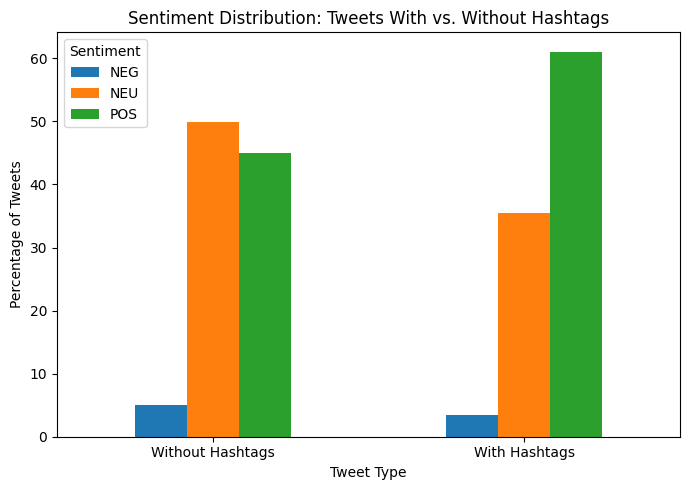

sentiment,NEG,NEU,POS
Without Hashtags,5.11,49.84,45.05
With Hashtags,3.46,35.48,61.06


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create two groups
EDA_DF["has_hashtag"] = EDA_DF["hashtags"].notna()

# Count of sentiment per group
sent_counts = pd.crosstab(EDA_DF["has_hashtag"], EDA_DF["sentiment"], normalize="index") * 100

# Plot as a grouped bar chart
sent_counts.index = ["Without Hashtags", "With Hashtags"]
sent_counts[["NEG", "NEU", "POS"]].plot(kind="bar", figsize=(7,5))
plt.title("Sentiment Distribution: Tweets With vs. Without Hashtags")
plt.ylabel("Percentage of Tweets")
plt.xlabel("Tweet Type")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Display numeric table to see exact values
display(sent_counts.round(2))



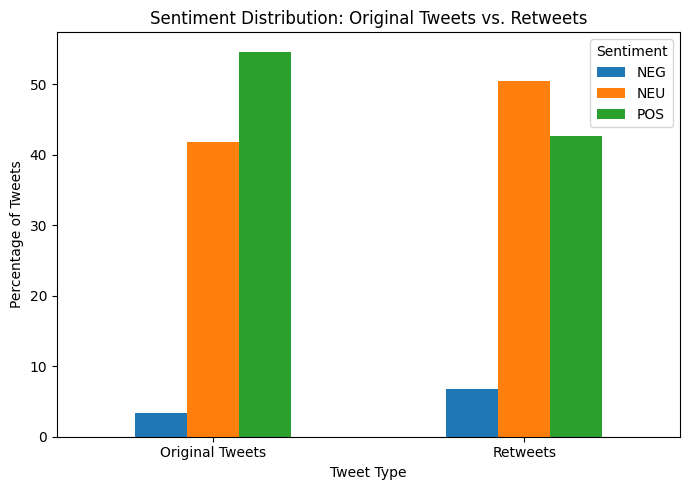

sentiment,NEG,NEU,POS
Original Tweets,3.43,41.90,54.67
Retweets,6.78,50.52,42.70


In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure the is_retweet column exists
EDA_DF["is_retweet"] = EDA_DF["text"].str.startswith("RT ")

# Create crosstab for sentiment vs. retweet status
sent_counts = pd.crosstab(EDA_DF["is_retweet"], EDA_DF["sentiment"], normalize="index") * 100

# Plot as a grouped bar chart
sent_counts.index = ["Original Tweets", "Retweets"]
sent_counts[["NEG", "NEU", "POS"]].plot(kind="bar", figsize=(7,5))
plt.title("Sentiment Distribution: Original Tweets vs. Retweets")
plt.ylabel("Percentage of Tweets")
plt.xlabel("Tweet Type")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#Display numeric table to see exact values
display(sent_counts.round(2))


In [62]:
EDA_DF[EDA_DF["cleaned_text"].str.contains("#TreCru", case=False, na=False)]["text"].head(100)


,text
40,Found a Transponder Snail!Candid shots of the Straw Hats on their new ship!https://t.co/lGcHiFpLmb #TreCru https://t.co/Ehk4w75cl2
111,"Found a Transponder Snail!Giants, sea monsters and other amazing encounters!https://t.co/p3DBLdzeo9 #TreCru https://t.co/9v4aD9DIAe"
262,"Found a Transponder Snail!Battle rages in Upper Yard! Shandians vs. ""Kami""!https://t.co/gR8k6hP6bz #TreCru https://t.co/TOAFHLus0d"
337,Found a Transponder Snail!Candid shots of the Straw Hats on their new ship!https://t.co/285zlYYJ8w #TreCru https://t.co/PumEIL0x7U
370,Found a Transponder Snail!Candid shots of the Straw Hats on their new ship!https://t.co/MUARWAYv9N #TreCru https://t.co/SWmOTO6xKI
...,...
9980,Found a Transponder Snail!Candid shots of the Straw Hats on their new ship!https://t.co/V3VpnL0Qxc #TreCru https://t.co/zZOjcnCOBe
9997,Found a Transponder Snail!Extra! Extra! Devil of Ohara captured by CP9!https://t.co/Bv9b7XHW2o #TreCru https://t.co/hmqdyxqfG4
10140,"Found a Transponder Snail!Giants, sea monsters and other amazing encounters!https://t.co/Oa0hfbppcv #TreCru https://t.co/RijZbwqDba"
10265,Found a Transponder Snail!Oars comes back as a henchman of Moria?!https://t.co/4gB0JdsulY #TreCru https://t.co/RRbMa8fW9U
